是的，你说得非常对 ✅

---

## 🧠 **模型微调（Fine-tuning）的基本思路**

当你使用**预训练模型**（如 ResNet、VGG、EfficientNet 等）时，通常会先**冻结部分层**（通常是前面的卷积层），只训练最后的全连接层（head）。这样做的目的是：

- 防止在初始阶段破坏预训练权重；
- 加快训练速度；
- 避免过拟合小数据集。

当这些头部已经训练得差不多之后，就可以开始**解冻之前的冻结层**，让整个模型（或部分层）一起参与训练，这就是所谓的 **微调（fine-tuning）**。

---

## 🔧 如何进行微调？步骤如下：

### ✅ 步骤 1：查看模型结构（可选）

你可以先打印模型结构，了解哪些层是你之前冻结过的。例如：

```python
print(model)
```

---

### ✅ 步骤 2：解冻之前冻结的层

假设你之前是这样冻结的（比如冻结了除最后一层外的所有层）：

```python
for param in model.parameters():
    param.requires_grad = False

# 只开启最后一层的梯度更新
for param in model.fc.parameters():  # 假设最后一层是 fc
    param.requires_grad = True
```

现在你想解冻所有层，只需要重新设置：

```python
for param in model.parameters():
    param.requires_grad = True
```

或者如果你只想解冻某些层（比如最后几层），可以这样做：

```python
# 解冻最后两层
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:  # 比如 layer4 和 fc 层
        param.requires_grad = True
    else:
        param.requires_grad = False
```

---

### ✅ 步骤 3：重新定义优化器（重要！）

当你修改了哪些参数需要更新后，必须**重新定义优化器**，否则它仍然只会更新原来那些 `requires_grad=True` 的参数。

比如你之前可能只训练最后一层：

```python
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
```

现在要改成训练整个模型（或你解冻的部分）：

```python
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # 更小的学习率更适合微调
```

> ⚠️ 微调阶段建议使用更小的学习率（如 `1e-5` 到 `1e-4`），避免破坏预训练好的特征提取层。

---

### ✅ 步骤 4：继续训练模型

你可以像往常一样使用你的 `fit_gpu` 函数来训练模型：

```python
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(...)
    val_loss, val_acc = evaluate(...)
    scheduler.step()  # 如果用了学习率调度器
```

---

## ✅ 示例：完整流程回顾

```python
# 1. 加载预训练模型
model = resnet18(pretrained=True)

# 2. 修改输出头（假设是分类任务）
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # 假设是 10 分类

# 3. 冻结除了最后一层外的所有层
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# 4. 定义优化器（只训练最后一层）
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# 5. 训练几个 epoch 后，进入 fine-tune 阶段
# 解冻所有层
for param in model.parameters():
    param.requires_grad = True

# 6. 重新定义优化器，学习率调低
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 7. 继续训练
for epoch in range(fine_tune_epochs):
    ...
```

---

## 📌 小贴士：微调最佳实践

| 技巧 | 说明 |
|------|------|
| 使用小学习率 | 微调时一般用 `1e-5` ~ `1e-4` |
| 先训练 head，再 fine-tune 整体 | 避免一开始就破坏特征提取能力 |
| 分层设置不同学习率（进阶） | 对底层用更小 lr，对高层用更大 lr |
| 使用余弦退火或 OneCycleLR | 提升微调效果 |

---

## ✅ 总结一句话：

> 要进行微调，你需要：
> 1. **解冻之前冻结的层**；
> 2. **重新定义优化器，使其包含这些新解冻的参数**；
> 3. **使用较小的学习率继续训练模型**。

如果你愿意告诉我你当前使用的模型结构（比如是 ResNet、VGG 还是自定义网络），我可以帮你写出具体的解冻代码 😊

In [1]:
import torch 
import torchvision
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import transforms 
from torch.utils.data import DataLoader,Dataset 

In [2]:
model = models.resnet18(pretrained=True)
model

D:\venvs\dl\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\venvs\dl\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
model.fc = nn.Linear(in_features=512,out_features=4) 
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters(): 
    param.requires_grad = True

In [5]:
transforms_Train = transforms.Compose(
     [
        #数据增强 
        transforms.Resize(224),
        transforms.RandomCrop(192),
        transforms.RandomHorizontalFlip(), #随机水平翻转 
        transforms.RandomRotation(degrees=20), #随机旋转  
        transforms.ColorJitter(brightness=0.5), #随机扰动
        transforms.ColorJitter(contrast=0.5), #增加对比度
        # transforms.Resize((192,192)), 
        transforms.ToTensor(), 
        transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]),
        
        
    ]
)

In [6]:
transforms_Tst = transforms.Compose(
    [
        transforms.Resize((192,192)),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
    ]
)

In [7]:
Train_DS = torchvision.datasets.ImageFolder(
    '../01计算机视觉基础/4weather/train', 
    transform = transforms_Train
)
Tst_DS = torchvision.datasets.ImageFolder(
    '../01计算机视觉基础/4weather/test/', 
    transform=transforms_Tst
)

In [8]:
Train_DL = DataLoader(Train_DS,batch_size=32,shuffle=True)
Tst_DL = DataLoader(Tst_DS,batch_size=64,shuffle=False)

In [9]:
#设置优化器 ,因为我们已经冻结了原来的层,这时候只需要关注最后一层就可以了
optimizer = torch.optim.Adam(model.fc.parameters(),lr=0.0001) #学习率不要太高,因为已经训练好了
#设置损失函数 
loss_fn = nn.CrossEntropyLoss()

In [10]:
def fit_gpu(Train_DL,TST_DL,Model_m,epoch_,optim,loss_fn): 
    correct = 0
    total = 0
    running_loss = 0
    tstcorrect = 0
    tsttotal = 0
    tstrunning_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
  
    Model_m.train()  # 设置为训练模式,此时dropout层会发挥作用
    for x, y in Train_DL:
        x = x.to(device)
        y = y.to(device)
        
        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        # 每个epoch结束后评估模型
        # 所有 batch 都训练完后，再计算整个 epoch 的准确率和损失
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)  #沿着类别维度找到最大值的索引位置
            correct += (y_pred == y).sum().item() #预测正确的个数
            # 因为(y_pred == y).sum()是一个张量,所以为了等式可以数值操作,我们用.item()取值
            total += y.size(0) #样本的个数,也就是size返回值的第一个返回值,即行数
            running_loss += loss.item()

        
    epoch_acc = correct/total
    epoch_loss = running_loss/len(Train_DL.dataset)

    #测试阶段 
    Model_m.eval() #转为eval()模式,此时dropout层不会起作用
    with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
         for x, y in TST_DL:
             x, y = x.to(device), y.to(device)
             y_pred =Model_m(x)
             loss = loss_fn(y_pred, y)
             
             y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
             tstcorrect += (y_pred == y).sum().item() #预测正确的个数
             tsttotal += y.size(0) #样本的个数
             tstrunning_loss += loss.item()
             
    tstepoch_acc = tstcorrect/tsttotal
    tstepoch_loss = tstrunning_loss/len(TST_DL.dataset)

    print(
        f'epoch:{epoch} | loss:{epoch_loss:.3f} | acc:{epoch_acc:.3f} | tstloss:{tstepoch_loss:.3f} | tstacc:{tstepoch_acc:.3f}'
    )

    return epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc


In [11]:
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[ 0.0279, -0.0239, -0.0226,  ...,  0.0229, -0.0441,  0.0368],
           [-0.0360,  0.0234, -0.0415,  ..., -0.0257, -0.0206, -0.0046],
           [ 0.0240,  0.0051,  0.0098,  ..., -0.0272, -0.0270,  0.0292],
           [ 0.0161, -0.0248,  0.0065,  ...,  0.0256,  0.0249, -0.0203]],
          requires_grad=True),
   Parameter containing:
   tensor([-3.7082e-02,  1.4880e-02, -5.4043e-05, -2.5816e-02],
          requires_grad=True)],
  'lr': 0.0001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': False,
  'differentiable': False,
  'fused': None,
  'decoupled_weight_decay': False}]

In [12]:

from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer=optimizer, step_size=5, gamma=0.9) #设置指定的优化器衰减策略,每5个epoch衰减一次,指定每次的被乘因子为0.9
train_loss_gpu = []
train_acc_gpu = []
tst_loss_gpu = []
tst_acc_gpu = []
epochs = 10

for epoch in range(epochs):
      # 每个 epoch 都训练
    epoch_loss, epoch_acc, tstepoch_loss, tstepoch_acc = fit_gpu(
        Train_DL=Train_DL,
        TST_DL=Tst_DL,
        Model_m=model,
        epoch_=epoch,
        optim=optimizer,
        loss_fn=loss_fn
    )
    
    # 记录指标
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: 学习率已更新为 {current_lr:.2e}")

epoch:0 | loss:0.051 | acc:0.193 | tstloss:0.024 | tstacc:0.324
Epoch 1: 学习率已更新为 1.00e-04
epoch:1 | loss:0.045 | acc:0.308 | tstloss:0.023 | tstacc:0.378
Epoch 2: 学习率已更新为 1.00e-04
epoch:2 | loss:0.042 | acc:0.358 | tstloss:0.021 | tstacc:0.427
Epoch 3: 学习率已更新为 1.00e-04
epoch:3 | loss:0.040 | acc:0.458 | tstloss:0.020 | tstacc:0.489
Epoch 4: 学习率已更新为 1.00e-04
epoch:4 | loss:0.037 | acc:0.536 | tstloss:0.019 | tstacc:0.587
Epoch 5: 学习率已更新为 9.00e-05
epoch:5 | loss:0.036 | acc:0.542 | tstloss:0.018 | tstacc:0.636
Epoch 6: 学习率已更新为 9.00e-05
epoch:6 | loss:0.034 | acc:0.618 | tstloss:0.017 | tstacc:0.622
Epoch 7: 学习率已更新为 9.00e-05
epoch:7 | loss:0.033 | acc:0.662 | tstloss:0.016 | tstacc:0.667
Epoch 8: 学习率已更新为 9.00e-05
epoch:8 | loss:0.031 | acc:0.693 | tstloss:0.016 | tstacc:0.684
Epoch 9: 学习率已更新为 9.00e-05
epoch:9 | loss:0.029 | acc:0.757 | tstloss:0.015 | tstacc:0.724
Epoch 10: 学习率已更新为 8.10e-05


## 解冻所有层,进入微调阶段 

In [13]:
for param in model.parameters(): 
    param.requires_grad = True

当你修改了哪些参数需要更新后，必须重新定义优化器，否则它仍然只会更新原来那些 requires_grad=True 的参数

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # 更小的学习率更适合微调

In [15]:

from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer=optimizer, step_size=5, gamma=0.9) #设置指定的优化器衰减策略,每5个epoch衰减一次,指定每次的被乘因子为0.9

# 不用新开列表,还用之前的,为了对比
# train_loss_gpu = []
# train_acc_gpu = []
# tst_loss_gpu = []
# tst_acc_gpu = []
extend_epochs = 20 #设置新的轮次

for epoch in range(extend_epochs):
      # 每个 epoch 都训练
    epoch_loss, epoch_acc, tstepoch_loss, tstepoch_acc = fit_gpu(
        Train_DL=Train_DL,
        TST_DL=Tst_DL,
        Model_m=model,
        epoch_=epoch,
        optim=optimizer,
        loss_fn=loss_fn
    )
    
    # 记录指标
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: 学习率已更新为 {current_lr:.2e}")

epoch:0 | loss:0.012 | acc:0.901 | tstloss:0.003 | tstacc:0.938
Epoch 1: 学习率已更新为 1.00e-04
epoch:1 | loss:0.005 | acc:0.954 | tstloss:0.002 | tstacc:0.964
Epoch 2: 学习率已更新为 1.00e-04
epoch:2 | loss:0.005 | acc:0.957 | tstloss:0.003 | tstacc:0.942
Epoch 3: 学习率已更新为 1.00e-04
epoch:3 | loss:0.005 | acc:0.949 | tstloss:0.003 | tstacc:0.956
Epoch 4: 学习率已更新为 1.00e-04
epoch:4 | loss:0.003 | acc:0.971 | tstloss:0.002 | tstacc:0.960
Epoch 5: 学习率已更新为 9.00e-05
epoch:5 | loss:0.003 | acc:0.980 | tstloss:0.003 | tstacc:0.956
Epoch 6: 学习率已更新为 9.00e-05
epoch:6 | loss:0.003 | acc:0.977 | tstloss:0.002 | tstacc:0.951
Epoch 7: 学习率已更新为 9.00e-05
epoch:7 | loss:0.003 | acc:0.974 | tstloss:0.003 | tstacc:0.947
Epoch 8: 学习率已更新为 9.00e-05
epoch:8 | loss:0.004 | acc:0.966 | tstloss:0.003 | tstacc:0.938
Epoch 9: 学习率已更新为 9.00e-05
epoch:9 | loss:0.003 | acc:0.972 | tstloss:0.003 | tstacc:0.951
Epoch 10: 学习率已更新为 8.10e-05
epoch:10 | loss:0.003 | acc:0.979 | tstloss:0.002 | tstacc:0.960
Epoch 11: 学习率已更新为 8.10e-05
epoch:1

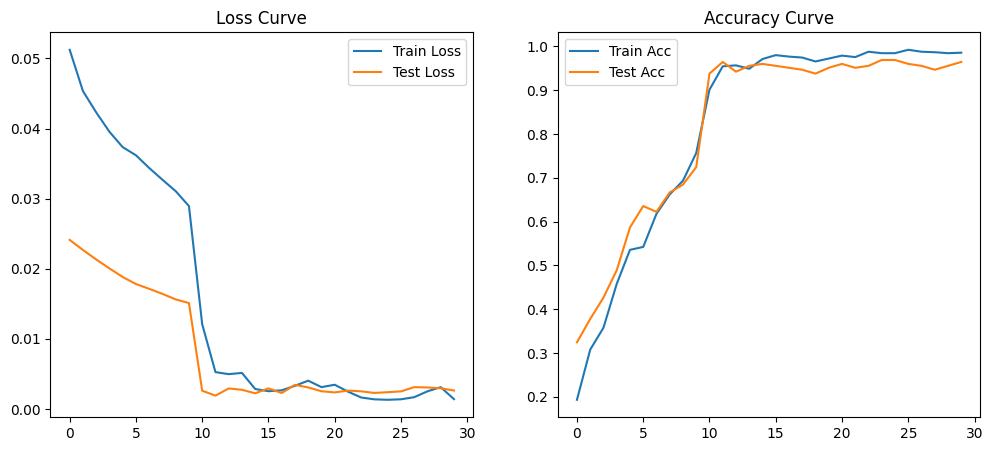

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_gpu, label='Train Loss')
plt.plot(tst_loss_gpu, label='Test Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_acc_gpu, label='Train Acc')
plt.plot(tst_acc_gpu, label='Test Acc')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

## 保存自己的模型 

### 查看模型的参数

In [17]:
model.state_dict() 

OrderedDict([('conv1.weight',
              tensor([[[[-7.0000e-03, -2.3495e-03,  1.8166e-03,  ...,  5.9951e-02,
                          2.0371e-02, -9.5416e-03],
                        [ 1.3928e-02,  1.2551e-02, -1.0681e-01,  ..., -2.6835e-01,
                         -1.2608e-01,  6.5436e-03],
                        [-4.6793e-03,  6.1694e-02,  2.9823e-01,  ...,  5.2224e-01,
                          2.5888e-01,  6.6088e-02],
                        ...,
                        [-2.5889e-02,  1.7907e-02,  7.4228e-02,  ..., -3.3137e-01,
                         -4.1908e-01, -2.5630e-01],
                        [ 3.2016e-02,  4.2341e-02,  6.3885e-02,  ...,  4.1487e-01,
                          3.9448e-01,  1.6673e-01],
                        [-1.2314e-02, -2.4136e-03, -2.3190e-02,  ..., -1.4997e-01,
                         -8.1513e-02, -5.2509e-03]],
              
                       [[-1.0137e-02, -2.4749e-02, -3.3025e-02,  ...,  3.3791e-02,
                          1.7452

In [18]:
torch.save(model.state_dict(),'./models/four_weather_finetuing.pth')

### 进行迁移学习 

D:\venvs\dl\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\venvs\dl\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


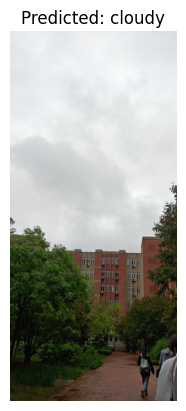

预测天气为: cloudy


In [20]:
from PIL import Image
# 类别名称（必须与训练时一致）
class_names = ['cloudy','rain','shine','sunrise']

# # 实例化模型
model = models.resnet18(pretrained=False)

model.fc = torch.nn.Linear(512, 4)  # 注意这里改成 4 类
# # 加载权重
model.load_state_dict(torch.load('./models/four_weather_finetuing.pth'))

# 检查是否有可用的GPU，如果有则使用，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 确保模型位于正确的设备上
model.to(device)


model.eval()  # 设置为评估模式

# 图像预处理（必须和训练时一致）
transform = transforms.Compose(
   [
        #数据增强 
        transforms.Resize(224),
        transforms.RandomCrop(192),
        transforms.RandomHorizontalFlip(), #随机水平翻转 
        transforms.RandomRotation(degrees=20), #随机旋转  
        transforms.ColorJitter(brightness=0.5), #随机扰动
        transforms.ColorJitter(contrast=0.5), #增加对比度
        # transforms.Resize((192,192)), 
        transforms.ToTensor(), 
        transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]),
        
        
    ]
)

# 读取图像
image_path = '../01计算机视觉基础/P20250517-081628.jpg'
image = Image.open(image_path).convert('RGB')

# 预处理 + 添加 batch 维度 (1, C, H, W)
image_tensor = transform(image).unsqueeze(0)
# 将输入数据移动到相同的设备上
image_tensor = image_tensor.to(device)
# 推理
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted_idx = torch.max(outputs, 1)
    predicted_class = class_names[predicted_idx.item()]

# 可视化结果
plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"预测天气为: {predicted_class}")

你看到的这两条警告信息是来自 `torchvision` 的：

```
UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
```

---

## 🔍 警告原因

这些警告是因为你使用了旧版的写法来加载模型，例如：

```python
model = models.resnet18(pretrained=False)
```

从 **torchvision 0.13** 开始，官方弃用了 `pretrained` 参数，推荐使用新的参数名 `weights` 来代替，并且这个参数接受的是一个 **枚举类型（Enum）**。

---

## ✅ 正确写法（更新你的代码）

### ✅ 1. 加载预训练模型（ImageNet）

如果你希望使用 ImageNet 上预训练的 ResNet18 模型（相当于以前的 `pretrained=True`）：

```python
import torchvision.models as models
import torchvision.models.resnet as resnet_weights

model = models.resnet18(weights=resnet_weights.ResNet18_Weights.IMAGENET1K_V1)
```

### ✅ 2. 不加载预训练权重（相当于以前的 `pretrained=False`）

```python
model = models.resnet18(weights=None)
```

### ✅ 3. 完整示例：用于微调并加载你自己保存的模型

```python
import torch
import torchvision.models as models
import torchvision.models.resnet as resnet_weights

# 创建模型，不加载 ImageNet 预训练权重
model = models.resnet18(weights=None)

# 修改最后一层为输出4类
model.fc = torch.nn.Linear(512, 4)

# 加载你自己保存的微调后的权重
model.load_state_dict(torch.load('./models/four_weather_finetuing.pth'))

# 移动到设备上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
```

---

## 🧠 小结

| 旧写法 | 新写法 |
|--------|--------|
| `pretrained=True` | `weights=resnet_weights.ResNet18_Weights.IMAGENET1K_V1` |
| `pretrained=False` | `weights=None` |

---

## 📌 常见模型对应的 weights 枚举类型

| 模型 | 对应 weights 类型 |
|------|------------------|
| ResNet18 | `resnet_weights.ResNet18_Weights.IMAGENET1K_V1` |
| ResNet50 | `resnet_weights.ResNet50_Weights.IMAGENET1K_V1` |
| VGG16    | `vgg_weights.VGG16_Weights.IMAGENET1K_V1` |
| MobileNetV2 | `mobilenet_weights.MobileNet_V2_Weights.IMAGENET1K_V1_0` |

---

如果你不确定某个模型支持哪些权重，可以打印出来看看：

```python
from torchvision.models import resnet18, ResNet18_Weights

print(ResNet18_Weights)  # 查看可用的预训练选项
```

---

如需我帮你改写整个模型定义或推理脚本，也可以告诉我 😊

In [25]:
model.to(device)
correct = 0
total = 0
running_loss = 0
tstcorrect = 0
tsttotal = 0
tstrunning_loss = 0
model.eval() #转为eval()模式,此时dropout层不会起作用
with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
     for x, y in Tst_DL:
         x, y = x.to(device), y.to(device)
         y_pred=model(x)
         loss = loss_fn(y_pred, y)
         y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
         tstcorrect += (y_pred == y).sum().item() #预测正确的个数
         tsttotal += y.size(0) #样本的个数
         tstrunning_loss += loss.item()
             
tstepoch_acc = tstcorrect/tsttotal
tstepoch_loss = tstrunning_loss/len(Tst_DL.dataset)
print(tstepoch_acc)

0.9644444444444444


## 如何使用最好的模型的权重呢 

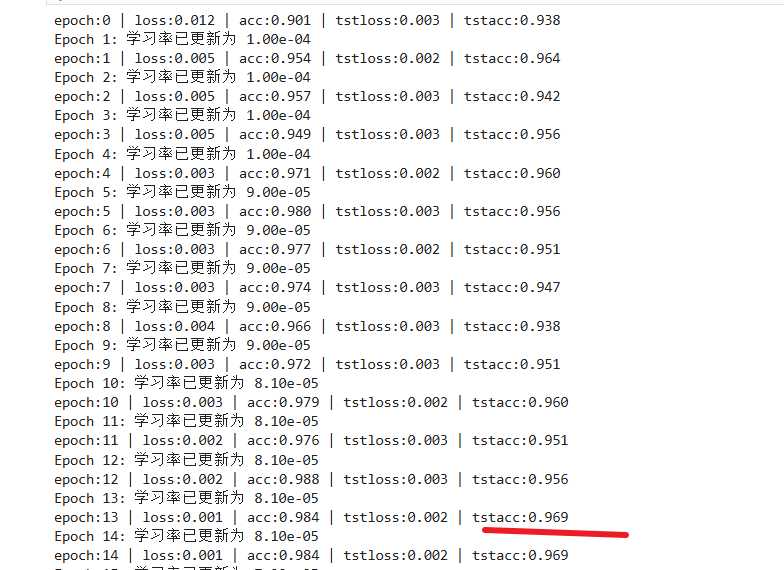

### 只需要修改开训即可 

In [ ]:

from torch.optim.lr_scheduler import StepLR
import copy
#预先定义最优模型的state_dict 
best_state = copy.deepcopy(model.state_dict())
best_acc = 0
scheduler = StepLR(optimizer=optimizer, step_size=5, gamma=0.9) #设置指定的优化器衰减策略,每5个epoch衰减一次,指定每次的被乘因子为0.9
train_loss_gpu = []
train_acc_gpu = []
tst_loss_gpu = []
tst_acc_gpu = []
epochs = 10

for epoch in range(epochs):
      # 每个 epoch 都训练
    epoch_loss, epoch_acc, tstepoch_loss, tstepoch_acc = fit_gpu(
        Train_DL=Train_DL,
        TST_DL=Tst_DL,
        Model_m=model,
        epoch_=epoch,
        optim=optimizer,
        loss_fn=loss_fn
    )
    #如果测试集的精确度大于最优精确度的话就更新精确度
    if tstepoch_acc > best_acc: 
        best_state = copy.deepcoopy(model.state_dict())
        best_acc = tstepoch_acc
        
    # 记录指标
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: 学习率已更新为 {current_lr:.2e}")

### 然后进入评测阶段

In [ ]:
# # 实例化模型
model = models.resnet18(pretrained=False)

model.fc = torch.nn.Linear(512, 4)  # 注意这里改成 4 类
# # 加载权重
model.load_state_dict(best_state)

# 检查是否有可用的GPU，如果有则使用，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 确保模型位于正确的设备上
model.to(device)
correct = 0
total = 0
running_loss = 0
tstcorrect = 0
tsttotal = 0
tstrunning_loss = 0
model.eval() #转为eval()模式,此时dropout层不会起作用
with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
     for x, y in Tst_DL:
         x, y = x.to(device), y.to(device)
         y_pred=model(x)
         loss = loss_fn(y_pred, y)
         y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
         tstcorrect += (y_pred == y).sum().item() #预测正确的个数
         tsttotal += y.size(0) #样本的个数
         tstrunning_loss += loss.item()
             
tstepoch_acc = tstcorrect/tsttotal
tstepoch_loss = tstrunning_loss/len(Tst_DL.dataset)
print(tstepoch_acc)